# MVA Cours Numerical PDEs for image analysis

## TP1.1 Sparse automatic differentiation

We implement a automatic differentiation class, using sparse storage, and explore some of its applications.

**Note:** 
The purpose of these experiments is to illustrate the conceptual simplicity of automatic differentiation.
In practical applications, it is not recommended to develop these tools from scratch, but to use a mature software package. (As we will do in next sessions.)

## 0. Importing the required libraries

In [33]:
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt

## 1. Implementation

In [6]:
class Sparse:
    """
    A class for Sparse, first order, forward automatic differentiation.
    Members : 
    - x : an array of arbitrary shape (n_1,...,n_k)
    - v : an array of shape (size_ad, n_1,...,n_k), where size_ad is arbitrary integer
    - i : an array of shape (size_ad, n_1,...,n_k).
    
    Represents the following Taylor expansion, where h is a symbolic perturbation
    x + sum(h[i[k]]*v[k] for k in range(size_ad)) + o(\|h\|)
    """
    
    def __init__(self,x,v,i):
        self.x = x
        self.v = np.asarray(v) 
        self.i = np.asarray(i)
        assert np.shape(x) == np.shape(v)[1:]
        assert np.shape(v) == np.shape(i)
    
    def __repr__(self):
        return f"Sparse({self.x},{self.v},{self.i})"
    
    @property
    def size_ad(self): return len(self.v)
    @property
    def shape(self): return np.shape(self.x)
    
    def convert(self,other,sshape=None):
        if sshape is None: sshape = self.shape
        if isinstance(other,Sparse): 
            assert other.shape == sshape
            return other
        else: # Broadcast other array, otherwise won't match
            shape_ad = (0,*sshape)
            return Sparse(np.broadcast_to(other,sshape),
                            np.zeros(shape_ad),np.zeros(shape_ad,dtype=int))
    
    # Base arithmetic operators
    def __add__(self,other):
        a,b = self,self.convert(other)
        return Sparse(a.x+b.x, np.concatenate([a.v,b.v]), np.concatenate([a.i,b.i]))
    
    def __sub__(self,other):
        a,b = self,self.convert(other)
        return Sparse(a.x-b.x,np.concatenate([a.v,-b.v]), np.concatenate([a.i,b.i]))
    
    def __mul__(self,other):
        a,b = self,self.convert(other)
        return Sparse(a.x*b.x, np.concatenate([b.x*a.v,a.x*b.v]), np.concatenate([a.i,b.i]))

    def __truediv__(self,other):
        a,b = self,self.convert(other)
        return Sparse(a.x/b.x, np.concatenate([a.v/b.x,- a.x*b.v/b.x**2]), np.concatenate([a.i,b.i]))

    # Other operators
    def __neg__(self): return Sparse(-self.x,-self.v, self.i)
    __radd__ = __add__
    __rmul__ = __mul__
    def __rsub__(self,other): return self.convert(other)-self
    def __rtruediv__(self,other): return self.convert(other)/self
    
    
    # Special functions
    def __pow__(self,r):
        x = self.x
        return Sparse(x**r, r*x**(r-1) * self.v, self.i)
    
    def sqrt(self): 
        s = np.sqrt(self.x)
        return Sparse(s, self.v/(2*s), self.i)
    
    def sin(self):
        s,c = np.sin(self.x),np.cos(self.x)
        return Sparse(s, c*self.v, self.i)
    
    def cos(self):
        s,c = np.sin(self.x),np.cos(self.x)
        return Sparse(c,-s*self.v, self.i)

    # Several dimensions
    def __getitem__(self,key):
        return Sparse(self.x[key],self.v[:,key], self.i[:,key])
    def __setitem__(self,key,other):
        a,b = self,self.convert(other,self.x[key].shape)
        assert a.size_ad>=b.size_ad # Ensure AD data will fit
        a.x[key]   = b.x
        a.v[:b.size_ad,key] = b.v
        a.v[b.size_ad:,key] = 0.
        a.i[:b.size_ad,key] = b.i
    def flatten(self):
        shape_ad = (self.size_ad,-1)
        return Sparse(np.reshape(self.x,-1),np.reshape(self.v,shape_ad), np.reshape(self.i,shape_ad))
    
    def sum(self,axis):
        assert axis==0
        shape_ad = (self.size_ad*x.shape[0],*x.shape[1:])           
        return Sparse(self.x.sum(axis),self.v.reshape(shape_ad),self.i.reshape(shape_ad))
    
    # Conversion of AD information to a sparse matrix
    def triplets(self):
        assert np.ndim(self.x)==1
        return (self.v.flatten(),(np.tile(np.arange(len(self.x)),self.size_ad), self.i.flatten()))
    def tocsr(self): return scipy.sparse.coo_matrix(self.triplets()).tocsr()
    def solve(self): return scipy.sparse.linalg.spsolve(self.tocsr(),-self.x)
        
# Create some sample variables for testing purposes
a = Sparse(1.,[1.,2.],[1,4]) # 1 + (h_1 + 2*h_4) + o(|h|)
b = Sparse(2.,[3.,4.],[0,1]) # 2 + (3*h_0+4*h_1) + o(|h|)

In [7]:
def close_to_zzero(a): 
    """Checks that a Taylor expansion has its zeroth and first order components close to zero."""
    m = a.flatten().tocsr() # Convert AD information to sparse matrix and compress
    return np.allclose(a.x,0) and np.allclose(m.data,0)

### 1.1 String representation

Implement the `Sparse.__repr__` method. It should return a string containing a readable representation of the object, that (ideally) can be used to reconstruct it.

In [8]:
print(a)

Sparse(1.0,[1. 2.],[1 4])


### 1.2 Arithmetic operators

*Task:* Implement the `Sparse.__add__` and `Sparse.__sub__` methods. They must return a `Sparse` object, in accordance with the Taylor expansion rules.
For instance:
$$
    (x+ \sum_{1 \leq k \leq K} v_k h_{i_k} + o(\|h\|)) + (x+ \sum_{1 \leq k \leq K'} v'_k h_{i'_k} + o(\|h\|)) 
    = (x+x') + (\sum_{1 \leq k \leq K} v_k h_{i_k} + \sum_{1 \leq k \leq K'} v'_k h_{i'_k}) + o(\|h\|)
$$

In [9]:
print(f"Addition : {a+b=}")     # Operator + is __add__
print(f"Substraction : {a-b=}") # Operator * is __sub__

Addition : a+b=Sparse(3.0,[1. 2. 3. 4.],[1 4 0 1])
Substraction : a-b=Sparse(-1.0,[ 1.  2. -3. -4.],[1 4 0 1])


In [10]:
assert close_to_zzero(a+b-a-b) # Unit test for checking implementation

*Task:* Implement the `Dense.__mul__` method, which must be in accordance with the following Taylor expansion:
$$
    (x + <v,h> + o(\|h\|)) + (x'+<v',h>+o(\|h\|)) = (x x') + <(x v'+x' v),h> + o(\|h\|)
$$

In [11]:
print(f"Multiplication {a*b=}")  # Operator * is __mul__
print(f"Division {a/b=}")        # Operator / is __truediv__

Multiplication a*b=Sparse(2.0,[2. 4. 3. 4.],[1 4 0 1])
Division a/b=Sparse(0.5,[ 0.5   1.   -0.75 -1.  ],[1 4 0 1])


In [12]:
assert close_to_zzero(a*b/a/b - 1) # Unit test for checking implementation

### 1.3 Other arithmetic operators

**Unary negation**

*Task:* Implement the unary negation `Sparse.__neg__` operator.

In [13]:
print(f"Unary negation {-a=}")

Unary negation -a=Sparse(-1.0,[-1. -2.],[1 4])


In [14]:
assert close_to_zzero(-a+a) # Unit test for checking implementation

**Operators acting on the right**

*Task:* Implement the `__rmul__` and `__rdiv__` operations, similar to the `Dense` case.

In [15]:
print(f"Right multiplication {2*a=}")
print(f"Right division {2/a=}")

Right multiplication 2*a=Sparse(2.0,[2. 4.],[1 4])
Right division 2/a=Sparse(2.0,[-2. -4.],[1 4])


In [16]:
assert close_to_zzero(2./(2./a) - a)

### 1.4 Special functions

Special functions, whose derivative is usually known explicitly, act on Taylor expansions as 
$$
    f(x + <v,h> + o(\|h\|)) = f(x) + <f'(x) v, h> + o(h).
$$

*Task:* Implement the `sqrt` and `sin` methods of the `Dense` class.

In [17]:
print(f"Square root function {np.sqrt(a)=}")
print(f"Sine function {np.sin(a)=}")

Square root function np.sqrt(a)=Sparse(1.0,[0.5 1. ],[1 4])
Sine function np.sin(a)=Sparse(0.8414709848078965,[0.54030231 1.08060461],[1 4])


In [18]:
assert close_to_zzero(np.sqrt(a**2)-a)
assert close_to_zzero(np.sin(np.pi-a) - np.sin(a))

## 2. Application to PDEs (One dimensional)

In this section, we apply the `Sparse` automatic differentiation class constructed to the solution of one dimensional PDEs.

**Disclaimer.** The examples presented below are only meant to illustrate how the `Sparse` automatic differentiation can be conveniently used to solve linear and non-linear PDEs. They have absolutely no interest for image processing and analysis (this will come in the next sessions).

Similar to the `Dense` case, we need to construct vectors with an independent symbolic perturbation for each coordinate.

*Task:* Implement the method `vector_ad` below which takes as input a vector $(x_i)_{1 \leq i \leq I}$ and returns a `Sparse` AD variable representing with an independent symbolic perturbation for each coordinate:
$$
    (x_i + h_i + o(\|h\|))_{1 \leq i \leq I}.
$$

In [19]:
def vector_ad(x):
    assert np.ndim(x)==1
    shape_ad = (1,len(x))
    return Sparse(x,np.ones(shape_ad),np.arange(len(x)).reshape(shape_ad))

In [20]:
x = np.linspace(0,1,10)
x_ad = vector_ad(x)

In [21]:
print(x_ad)

Sparse([0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ],[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]],[[0 1 2 3 4 5 6 7 8 9]])


The first matrix representing the first order perturbations is the identity.

In [22]:
print(x_ad.tocsr().todense())

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [23]:
assert np.allclose(x_ad.tocsr().todense(),np.eye(len(x)))

### 2.1 Solve the Poisson equation

We solve the Poisson equation with boundary conditions, which reads
$$
    - u''(x) = f(x), \forall x \in ]x_0,x_1[,
    \qquad
    u(x_0) = u_0, \ u(x_1) = u_1 
$$
where $[x_0,x_1]\subset R$ is an interval, the PDE domain, $f : [s_0,s_1] \to R$ is a given r.h.s, and $u_0,u_1$ are given Dirichlet boundary conditions.

**Note:** in the next sessions, we will solve multi-dimensional anisotropic variants of the Poisson equation, with applications to image denoising and enhancement.

In [24]:
X,dx = np.linspace(-np.pi,np.pi,10,retstep=True) # Only 10 grid points for plotting matrices.
f = np.sin(X)+np.abs(x)
bc = [0,1]

In [25]:
def roll(a,shift):
    """Roll a numpy array or a Sparse variable, along first axis, by prescribed shift"""
    if isinstance(a,np.ndarray): return np.roll(a,shift,axis=0)
    else: return Sparse(np.roll(a.x,shift,axis=0),np.roll(a.v,shift,axis=1),np.roll(a.i,shift,axis=1))

*Task:* Implement a function `Poisson(u,f,bc,h)` which returns the residue of the following numerical scheme
$$
    \frac{u(x+h)-2 u(x) + u(x-h)}{h^2} + f(x) = 0, x \in \{x_0+h, x_0+2h, \cdots, x_1-h\} \qquad
    u(x_0) - u_0 = 0, u(x_1)-u_1 = 0.
$$

In [26]:
def Poisson(u,f,bc,dx):
    residue = -(roll(u,1)-2*u+roll(u,-1))/dx**2 - f
    residue[0] = u[0]-bc[0]
    residue[-1] = u[-1]-bc[1]
    return residue

In [27]:
u = np.zeros_like(X)
Poisson(u,f,bc,dx) # Non-zero residue : u is not the solution

array([ 0.        ,  0.5316765 ,  0.76258553,  0.53269207, -0.1024243 ,
       -0.8975757 , -1.53269207, -1.76258553, -1.5316765 , -1.        ])

In [28]:
u_ad = vector_ad(u)
res = Poisson(u_ad,f,bc,dx)

In [29]:
print(res.tocsr().todense().round(2)) # One should recognize the matrix of a Laplacian with second order finite differences.

[[ 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-2.05  4.1  -2.05  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -2.05  4.1  -2.05  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.   -2.05  4.1  -2.05  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -2.05  4.1  -2.05  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -2.05  4.1  -2.05  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -2.05  4.1  -2.05  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -2.05  4.1  -2.05  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -2.05  4.1  -2.05]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]]


Consider a Taylor expansion written in the generic form
$$
    x + L h + o(h)
$$
where $x\in R^n$ is a *vector*, $L$ is a *matrix* of size $m \times n$, and $h \in R^m$ is a symbolic perturbation.

Our `Sparse` class encodes Taylor expansions of this form, where $L$ is given in ad-hoc format.
The `Sparse.solve` returns the solution $h_*$, if it exists, of 
$$
    x+L h_* = 0
$$

*Task:* use this method to solve the finite differences scheme of the Poisson equation.

In [34]:
sol = res.solve()

In [35]:
assert np.allclose(Poisson(sol,f,bc,dx),0)

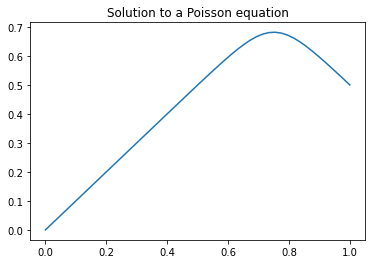

In [42]:
plt.title("Solution to a Poisson equation")
plt.plot(X,sol);

*Task:* Repeat the above with a larger number of discretization points. 
You may also, check the validity of the result using an instance of the Poisson problem with a known solution.

### 2.2 Solve a non-linear PDE

We propose to implement and solve the following non-linear PDE
$$
    -\epsilon \Delta u + u'^2 = f,
    \qquad u(0)=u_0, u(1)=u_1.
$$
(This is a viscous relaxation of the one-dimensional eikonal equation.)

**Note:** in the next sessions, we will solve multi-dimensional anistropic variants of the eikonal equation, with applications to image segmentation.

*Task:* Implement a centered finite-differences scheme for the above PDE.

In [37]:
def Nonlinear(u,f,eps,bc,dx):
    """Residue of the discretization of the nonlinear PDE -eps*u'' + u'^2 = f, with provided boundary conditions"""
    residue = - eps*(roll(u,1)-2*u+roll(u,-1))/dx**2 + (roll(u,1)-roll(u,-1))**2/(2*dx)**2 - f
    residue[0] = u[0]-bc[0]
    residue[-1] = u[-1]-bc[1]
    return residue

*Task:* Implement a newton solver based on sparse automatic differentiation.

In [38]:
def Newton(F,x,niter,params=tuple()):
    x_ad = vector_ad(x.copy())
    for i in range(niter):
        x_ad.x += F(x_ad,*params).solve()
    return x_ad.x

In [39]:
X,dx = np.linspace(0,1,retstep=True)
f = 1
eps=0.1
bc=[0,0.5]

params = (f,eps,bc,dx)
u=np.zeros_like(X)

In [40]:
sol = Newton(Nonlinear,u,10,params=params)

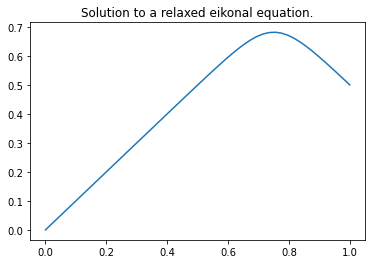

In [41]:
plt.title("Solution to a relaxed eikonal equation.")
plt.plot(X,sol);